<a href="https://colab.research.google.com/github/gihon27/Tugas_Machine_Learning/blob/main/Exam_%5BPaper2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd #import library
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, accuracy_score
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
data = '/content/Tweets.csv' #import data
df = pd.read_csv(data) #mebaca isi data
df.head() 

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0.0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0.0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0.0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df.columns #menampilkan kolom

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [6]:
df.isnull().sum() #menjumlahkan nilai

tweet_id                            0
airline_sentiment                   1
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             1
airline_sentiment_gold          14601
name                                1
negativereason_gold             14609
retweet_count                       1
text                                1
tweet_coord                     13622
tweet_created                       2
tweet_location                   4735
user_timezone                    4822
dtype: int64

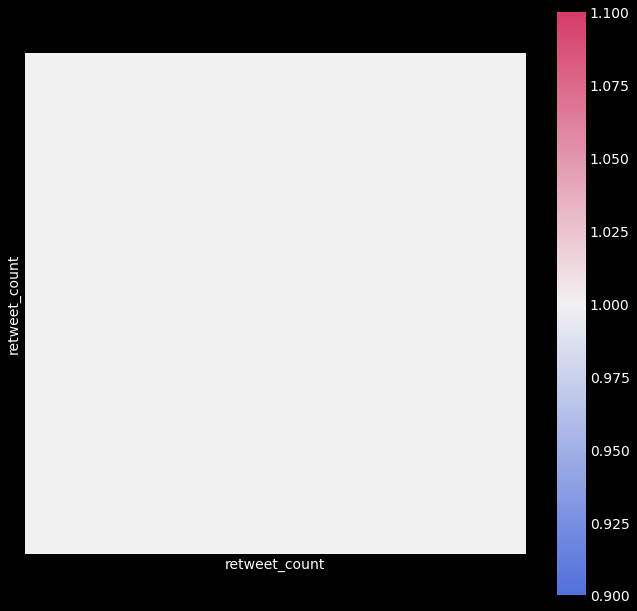

In [7]:
plt.figure(figsize = (10,10)) #Fungsi di matplotlib untuk membuat gambar  10 x 10 piksel
corr = df.corr() #Fungsi untuk menemukan korelasi berpasangan dari semua kolom 
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True) # Fungsi untuk membuat matrixplot

In [8]:
#Fungsi memfilter data yang tidak penting untuk memudahkan pemrosesan data yang relevan
unused_data = df[['tweet_id', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_location', 'user_timezone', 'name', 'retweet_count', 'tweet_created']]
df = df.drop(columns=unused_data) 
df

,airline_sentiment,airline_sentiment_confidence,airline,text
0,neutral,1.0,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,1.0,Virgin America,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...
14636,negative,1.0,US Airways,@USAirways is utterly unreliable! They didn't ...
14637,negative,1.0,US Airways,@USAirways yes but again valuable time has bee...
14638,negative,1.0,US Airways,@USAirways I don't like being lied to. No bad ...
14639,negative,1.0,US Airways,@USAirways yes it landed at 11:40am. Should no...


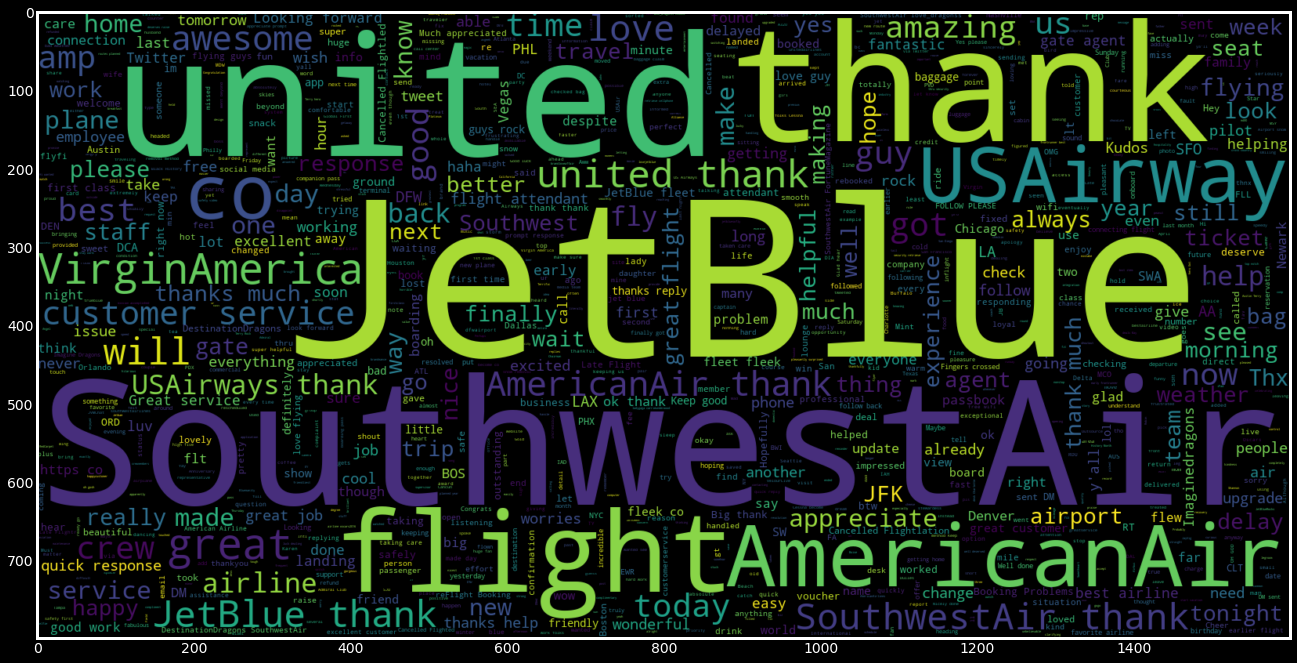

In [9]:
plt.figure(figsize = (20,20)) #Fungsi  mengatur ukuran gambar
plt.grid(False) #Fungsi membuat gridlines
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'positive'].text)) #FUngsi mengatur tinggi lebar dan maksimal kata yang ditampilkan
plt.imshow(wc , interpolation = 'bilinear') #Fungsi menampilkan gambar dengan interpolasi bilinear

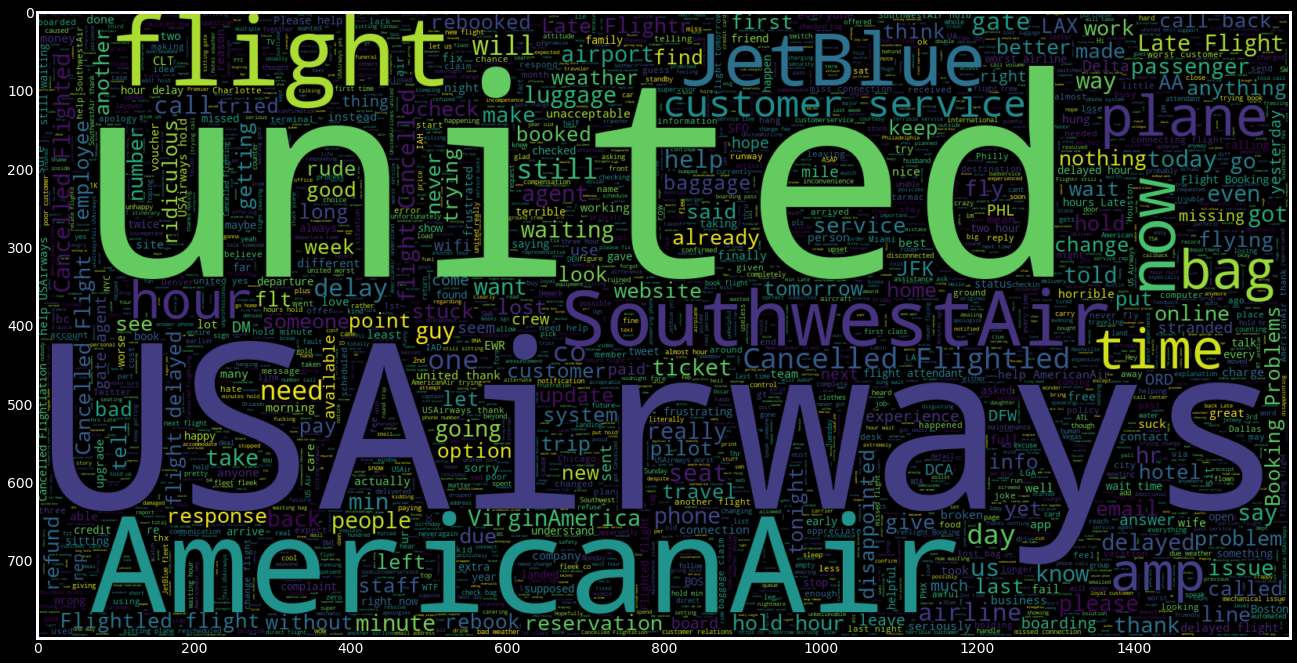

In [10]:
plt.figure(figsize = (20,20)) #Mengatur gambar
plt.grid(False) #Fungsi  membuat gridlines
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'negative'].text)) #FUngsi mengatur tinggi lebar dan maksimal kata yang ditampilkan
plt.imshow(wc , interpolation = 'bilinear') #Fungsi menampilkan gambar dengan interpolasi bilinear

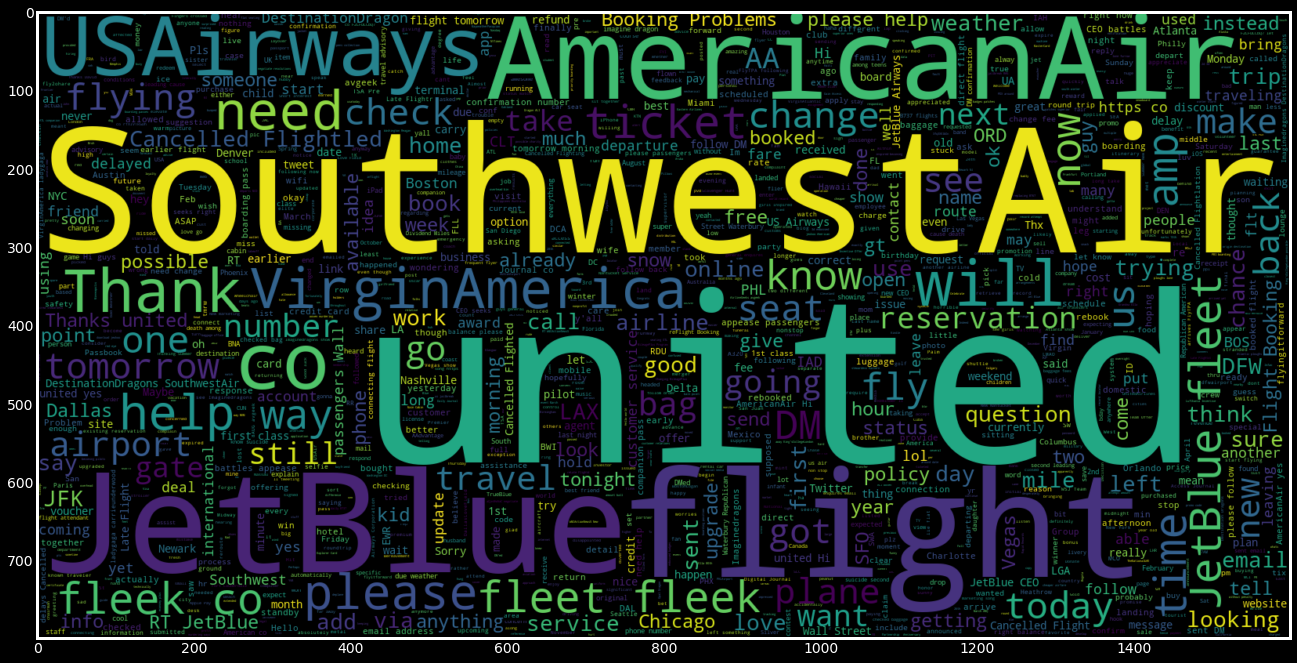

In [11]:
plt.figure(figsize = (20,20)) #Mengatur ukuran gambar
plt.grid(False) #Fungsi sebagai membuat gridlines
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.airline_sentiment == 'neutral'].text)) #FUngsi mengatur tinggi lebar dan maksimal kata yang ditampilkan
plt.imshow(wc , interpolation = 'bilinear') #Fungsi menampilkan gambar dengan interpolasi bilinear

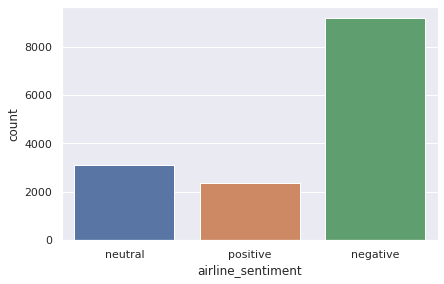

In [12]:
sns.set(style="darkgrid") #Fungsi mengatur tema plot dan latar belakang
sns.countplot(x = "airline_sentiment" , data = df) #Fungsi menjumlahkan data sesuai kategori

In [13]:
def clean_the_tweet(text):  #Fungsi digunakan untuk meluruskan format tweet yang salah, salah satunya huruf kapital menjadi huruf kecil
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

def text_process(msg): #Fungsi akan membuang kata yang tidak memiliki arti dalam bahasa inggris
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])
 
def check_scores(clf, X_train, X_test, y_train, y_test): # Pengecekan skor pada kata
  model = clf.fit(X_train, y_train)
  predicted_class = model.predict(X_test)
  predicted_class_train = model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))
  print()

  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()

  print(classification_report(y_test,predicted_class)) 
  print() 

  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Membuat Grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  # Membuat Grid mengisi ruang kosong
  grid.fit(X_train,Y_train)
  print()
  print()
  # Model Grid
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model

In [14]:
df = df[df['airline_sentiment']!='neutral'] # Filter tweet dengan sentimen positif
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

TypeError: ignored

In [ ]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process) # FUngsi untuk memfilter kata yang tidak relevan
df.reset_index(drop=True, inplace = True)
df.head()

In [ ]:
df['airline_sentiment'].unique() #FUngsi Load data yang ada ditabel airline_sentiment

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)

In [ ]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)

model=Sequential()
model.add(Dense(512, input_dim = max_sent_length, activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape, y_final.shape

In [ ]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_NN, y_train_NN, validation_data = (X_test_NN, y_test_NN), epochs=10, batch_size=64)

In [ ]:
y_test_pred_NN=np.round(model.predict(X_test_NN))
y_train_pred_NN=np.round(model.predict(X_train_NN))
y_test_pred_NN

In [ ]:
test_acc_NN = accuracy_score(y_test_NN, y_test_pred_NN)
train_acc_NN = accuracy_score(y_train_NN, y_train_pred_NN)
test_roc_NN = roc_auc_score(y_test_NN, y_test_pred_NN)
train_roc_NN = roc_auc_score(y_train_NN, y_train_pred_NN)

In [ ]:
corpus = [df['cleaned_tweet'][i] for i in range( len(df))]

voc_size=5000

onehot_=[one_hot(words,voc_size)for words in corpus] 

max_sent_length=max([len(i) for i in corpus])

embedded_docs=pad_sequences(onehot_,padding='pre',maxlen=max_sent_length)
    
embedding_vector_features=64
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=max_sent_length))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_final=np.array(embedded_docs)
y_final=np.array(df['airline_sentiment'])
X_final.shape,y_final.shape

In [ ]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_final, y_final, test_size=0.3, random_state=42)
model.fit(X_train_LSTM, y_train_LSTM, validation_data = (X_test_LSTM, y_test_LSTM), epochs=10, batch_size=64)

In [ ]:
y_test_pred_LSTM=np.round(model.predict(X_test_LSTM))
y_train_pred_LSTM=np.round(model.predict(X_train_LSTM))
y_test_pred_LSTM

In [ ]:
test_acc_LSTM = accuracy_score(y_test_LSTM, y_test_pred_LSTM)
train_acc_LSTM = accuracy_score(y_train_LSTM, y_train_pred_LSTM)
test_roc_LSTM = roc_auc_score(y_test_LSTM, y_test_pred_LSTM)
train_roc_LSTM = roc_auc_score(y_train_LSTM, y_train_pred_LSTM)

In [ ]:
m_naive_bayes = MultinomialNB()
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(m_naive_bayes ,x_train, x_test, y_train, y_test)

In [ ]:
rf = RandomForestClassifier(random_state=0)
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(rf, x_train, x_test, y_train, y_test)

In [ ]:
SVM = svm.SVC(probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM, x_train, x_test, y_train, y_test)

In [ ]:
parameters ={
    "C":[0.001, 0.1, 1, 10],
    "kernel":['linear', 'rbf', 'sigmoid', 'poly'],
    "gamma":['scale', 'auto']
}

In [ ]:
svm_optimized = grid_search(svm.SVC(probability=True), parameters,x_train, y_train) #Mengoptimasi Parameter

In [ ]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimized,x_train, x_test, y_train, y_test)

In [ ]:
# Fungsi merangkum hasil dari algoritma yang digunakan lalu menampilkannya
data = [('Artificial Neural Network',train_acc_NN, test_acc_NN, train_roc_NN, test_roc_NN),
        ('LSTM',train_acc_LSTM, test_acc_LSTM, train_roc_LSTM, test_roc_LSTM),
        ('Multinomial Naive Bayes',m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc),
        ('Random Forest', r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc),
        ('SVM', s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc),
        ('SVM Optimized', so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc)]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy', 'Train ROC', 'Test ROC'])
Scores_.set_index('Model Name', inplace = True)

Scores_